In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline
#%matplotlib widget
plt.rcParams['figure.facecolor'] = '#a9c3f3af'
from IPython.display import HTML, display
display(HTML("""
<style>
.cell-output-ipywidget-background,
.cell-output-ipywidget-background * {
    background-color: transparent !important;
    color: white !important;   /* make all text white */
}
</style>
"""))

import sympy as sp
from PIL import Image

In [2]:
folder = "imgs/"

In [3]:
arr = [cv2.imread(folder+file) for file in sorted(os.listdir(folder)) if file.endswith('.png') or file.endswith('.jpg')]
arr[1].shape

# images dont have the same shape!!! Resize them to the largest one
max_shape = np.max([img.shape for img in arr], axis=0)

shape_scaler = 2

max_shape = (max_shape[0]*shape_scaler, max_shape[1]*shape_scaler, max_shape[2])  # drop channels

max_shape


(np.int64(844), np.int64(1126), np.int64(3))

In [4]:
resized_images = [cv2.resize(img, (max_shape[1], max_shape[0])) for img in arr]

In [5]:
images = np.array(resized_images)

In [6]:
gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

In [7]:
# fix widget height so it doesnt jump around
out = widgets.Output(layout={'height': '500px', 'width': '600px'})

def image_viewer(color_imgs, gray_imgs):
    @widgets.interact(image_nr=(0, len(color_imgs)-1, 1))
    def _viewer(image_nr=0):
        with out:
            out.clear_output(wait=True)
            fig, ax = plt.subplots(1, 2, figsize=(6, 4))
            ax[0].imshow(color_imgs[image_nr])
            ax[0].axis("off")
            ax[0].set_title("Color Image")
            ax[1].imshow(gray_imgs[image_nr], cmap='gray')
            ax[1].axis("off")
            ax[1].set_title("Grayscale Image")
            plt.show()

In [8]:
image_viewer(color_imgs=images, gray_imgs=gray_images)
display(out)

interactive(children=(IntSlider(value=0, description='image_nr', max=3), Output()), _dom_classes=('widget-inte…

Output(layout=Layout(height='500px', width='600px'))

In [9]:
@widgets.interact(
    image_nr=(0, len(gray_images) - 1, 1),
    threshold1=(0, 255, 1),
    threshold2=(0, 255, 1)
)
def edge_viewer(image_nr=0, threshold1=63, threshold2=109):
    global edge_imags
    edge_imags = [(cv2.Canny(gray_img, threshold1, threshold2)) for gray_img in gray_images]

    fix, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.imshow(edge_imags[image_nr], cmap='gray')
    ax.axis("off")
    plt.show()

interactive(children=(IntSlider(value=0, description='image_nr', max=3), IntSlider(value=63, description='thre…

In [10]:
@widgets.interact(threshold=(0, 500, 1), img_nr=(0, len(edge_imags)-1, 1))
def hough_line_viewer(threshold=103, img_nr=1):
    global lines
    lines = cv2.HoughLines(edge_imags[img_nr], 1, np.pi / 180, threshold)  # img, rho_res (pixels), theta_res (radians), threshold (min votes for accumulator)

    img_copy = images[img_nr].copy()  # Create a copy to avoid modifying the original image
    if lines is not None:
        diag = int(np.hypot(img_copy.shape[0], img_copy.shape[1]))  # image diagonal
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + diag * (-b))
            y1 = int(y0 + diag * (a))
            x2 = int(x0 - diag * (-b))
            y2 = int(y0 - diag * (a))
            cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

    plt.imshow(img_copy)
    plt.axis("off")
    plt.show()


interactive(children=(IntSlider(value=103, description='threshold', max=500), IntSlider(value=1, description='…

In [11]:
lines[0][0][0]

np.float32(671.0)

In [12]:
# create smpy vector v1
v = sp.Matrix([sp.cos(sp.symbols('theta')), sp.sin(sp.symbols('theta'))])
v

Matrix([
[cos(theta)],
[sin(theta)]])

In [13]:
v1 = v.subs(sp.symbols('theta'), lines[0][0][1]) * lines[0][0][0]
v1

Matrix([
[ 670.08],
[35.1174]])

In [14]:
v2 = v.subs(sp.symbols('theta'), lines[2][0][1]) * lines[2][0][0]
v2

Matrix([
[-47.9227],
[ 685.327]])

[]

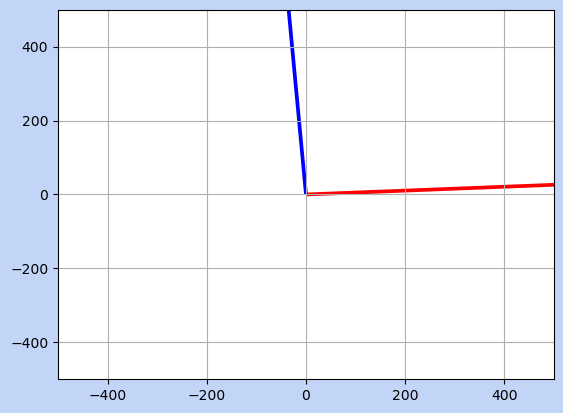

In [15]:
# draw the vectors to see if they are orthogonal
# one should check if the rho and theta are similar
# if so skipt those, since its probably the same line
origin = np.array([[0, 0], [0, 0]])  # origin point
v1_np = np.array(v1).astype(np.float64).flatten()  # Convert v1 to a numpy array
v2_np = np.array(v2).astype(np.float64).flatten()  # Convert v2 to a numpy array
plt.quiver(*origin, [v1_np[0], v2_np[0]], [v1_np[1], v2_np[1]], color=['r', 'b'], angles='xy', scale_units='xy', scale=1)
plt.xlim(-500, 500)
plt.ylim(-500, 500)
plt.grid()
plt.plot()

In [16]:
l1 = v1 + sp.Matrix([-sp.sin(sp.symbols('theta')), sp.cos(sp.symbols('theta'))]) * sp.symbols('lambda1')
l1 = l1.subs(sp.symbols('theta'), lines[0][0][1])
l1

Matrix([
[670.08 - 0.052336*lambda1],
[0.99863*lambda1 + 35.1174]])

In [17]:
l2 = v2 + sp.Matrix([-sp.sin(sp.symbols('theta')), sp.cos(sp.symbols('theta'))]) * sp.symbols('lambda2')
l2 = l2.subs(sp.symbols('theta'), lines[2][0][1])
l2

Matrix([
[-0.997564*lambda2 - 47.9227],
[685.327 - 0.0697565*lambda2]])

In [18]:
# create sympy equation system
eq1 = sp.Eq(l1, l2)
eq1

Eq(Matrix([
[670.08 - 0.052336*lambda1],
[0.99863*lambda1 + 35.1174]]), Matrix([
[-0.997564*lambda2 - 47.9227],
[685.327 - 0.0697565*lambda2]]))

In [19]:
# solve the equation system
solution = sp.solve(eq1, (sp.symbols('lambda1'), sp.symbols('lambda2')))
solution

{lambda1: 698.816607951428, lambda2: -683.093750382185}

[]

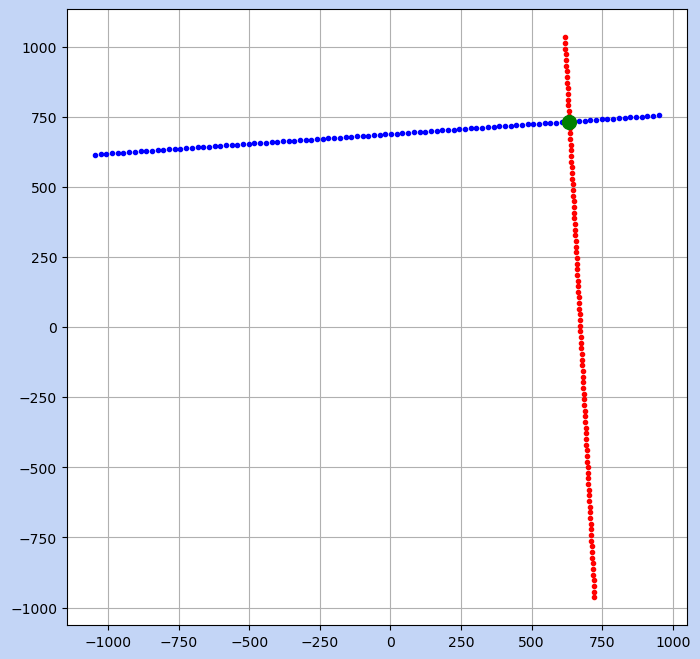

In [20]:
# draw l1 and l2
lambda1, lambda2 = sp.symbols('lambda1 lambda2')
lambda1_vals = np.linspace(-1000, 1000, 100)
lambda2_vals = np.linspace(-1000, 1000, 100)
plt.figure(figsize=(8, 8))
for lam1 in lambda1_vals:
    point = np.array(l1.subs(lambda1, lam1)).astype(np.float64).flatten()
    plt.plot(point[0], point[1], 'r.')
for lam2 in lambda2_vals:
    point = np.array(l2.subs(lambda2, lam2)).astype(np.float64).flatten()
    plt.plot(point[0], point[1], 'b.')
#plt.xlim(-500, 500)
#plt.ylim(-500, 500)

# add the calculated intersection point
intersection_point = np.array(l1.subs(lambda1, solution[sp.symbols('lambda1')])).astype(np.float64).flatten()
plt.plot(intersection_point[0], intersection_point[1], 'go', markersize=10)

plt.grid()
plt.plot()